In [1]:
# 目前已经了解了如何定义神经网络，计算损失值和网络里权重的更新。

# 通常来说，当你处理图像，文本，语音或者视频数据时，你可以使用标准 python 包将数据加载成 numpy 数组格式，
# 然后将这个数组转换成 torch.*Tensor
# --- 对于图像，可以用 Pillow，OpenCV
# --- 对于语音，可以用 scipy，librosa
# --- 对于文本，可以直接用 Python 或 Cython 基础数据加载模块，或者用 NLTK 和 SpaCy

# 特别是对于视觉，我们已经创建了一个叫做totchvision的包，
# 该包含有支持加载类似Imagenet，CIFAR10，MNIST 等公共数据集的数据加载模块torchvision.datasets 
# 和支持加载图像数据数据转换模块 torch.utils.data.DataLoader。
# 这提供了极大的便利，并且避免了编写“样板代码”。

# 总结一下，torch提供了torchvision.datasets包含了常用的图像数据集，torch.utils.data.Dataloader用来加载数据

# 对于本教程，我们将使用CIFAR10数据集，它包含十个类别：‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, 
# ‘horse’, ‘ship’, ‘truck’。
# CIFAR-10 中的图像尺寸为3*32*32，也就是RGB的3层颜色通道，每层通道内的尺寸为32*32。

In [2]:
# 训练一个图像分类器
# 我们将按次序的做如下几步：
# 1）使用torchvision加载并且归一化CIFAR10的训练和测试数据集
# 2）定义一个卷积神经网络
# 3）定义一个损失函数
# 4）在训练样本数据上训练网络
# 5）在测试样本数据上测试网络


In [4]:
# 1）加载并归一化CIFAR10，使用torchvision, 用它来加载CIFAR10数据非常简单。
# torchvision数据集的输出是范围在[0,1]之间的PILImage，我们将他们转换成归一化范围为[-1,1]之间的张量Tensors。

# torchvision.transforms的介绍可以参考
# https://www.jianshu.com/p/1ae863c1e66d

import torch
import torchvision
import torchvision.transforms as transforms

# Compose接受一个transform列表，内部__call__就是依次调用这些transform来处理图片
# ToTensor目的是将PILImage或者numpy.ndarray转成Tensor对象
# Normalize是做归一化的，这里两个tuple似乎对应mean/std，(0.5, 0.5, 0.5)难道对应RGB？
# Resize类是对PILImage做resize操作的，传入一个int对短边缩放到这个int对长边按比例，传两个int则两边就按这个resize
# CenterCrop是以输入图的中心点为中心点做指定size的crop操作，一般数据增强不会采用这个
# RandomCrop：相比前面的CenterCrop，这个RandomCrop更常用，差别就在于crop时的中心点坐标是随机的，并不是输入图像的中心点坐标，因此基本上每次crop生成的图像都是有差异的
# RandomHorizontalFlip类也是比较常用的，是随机的图像水平翻转，通俗讲就是图像的左右对调。
# RandomVerticalFlip类是随机的图像竖直翻转，通俗讲就是图像的上下对调。
# RandomResizedCrop：该类主要用到3个参数：size、scale和ratio，总的来讲就是先做crop（用到scale和ratio），再resize到指定尺寸（用到size）
# FiveCrop类，顾名思义就是从一张输入图像中crop出5张指定size的图像，这5张图像包括4个角的图像和一个center
# TenCrop类和前面FiveCrop类类似，只不过在FiveCrop的基础上，再将输入图像进行水平或竖直翻转，然后再进行FiveCrop操作，这样一张输入图像就能得到10张crop结果
# LinearTransformation类是用一个变换矩阵去乘输入图像得到输出结果。
# ColorJitter类也比较常用，主要是修改输入图像的4大参数值：brightness, contrast and saturation，hue，也就是亮度，对比度，饱和度和色度。可以根据注释来合理设置这4个参数
# RandomRotation类是随机旋转输入图像，也比较常用，具体参数可以看注释，在F.rotate()中主要是调用PILImage的rotate方法
# Grayscale类是用来将输入图像转成灰度图的，这里根据参数num_output_channels的不同有两种转换方式
# RandomGrayscale类和前面的Grayscale类类似，只不过变成了按照指定的概率进行转换。
transform = transforms.Compose(
    [transforms.ToTensor(), 
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) #给[0.5, 0.5, 0.5]或者(0.5, 0.5, 0.5)都ok

# 拉取train dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
# 加载train dataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

# 拉取test dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
# 加载test dataset
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


len images: 4
image size: torch.Size([3, 32, 32])
torch.Size([3, 36, 138])
(3, 36, 138)
(36, 138, 3)


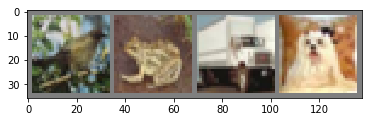

 bird  frog truck   dog


In [6]:
# 让我们来展示其中的一些训练图片。
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    #归一化的方式为 新数据=(老数据-mean)/std  所以逆回来就是 老数据=新数据*std + mean，即 老数据 = 新*0.5+0.5=新/2+0.5
    img = img / 2 + 0.5     # unnormalize，这块不懂了。。。。
    print(img.shape) #输出 torch.Size([3, 36, 138])
    npimg = img.numpy()
    # np.transpose对于一维数组没作用，对二维相当于转置，对此相当于将原来的012维转成120维的顺序
    #plt.imshow(np.transpose(npimg, (1, 2, 0))) 
    print(npimg.shape) #输出 (3, 36, 138)
    print(np.transpose(npimg, (1,2, 0)).shape) # 输出(36, 138, 3)，分别是高宽和RGB三个通道，这个是imshow函数要求的
    plt.imshow(np.transpose(npimg, (1,2, 0))) 
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
print('len images:', len(images)) # 输出4，因为dataloader里定义了batch size为4，所以一次iter返回4张图片
print('image size:', images[0].size()) # 输出torch.Size([3, 32, 32])，RGB3个通道，每个通道32*32像素

# show images
# make_grid的作用是将若干幅图像拼成一幅图像
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


In [8]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # 3 input channel, 6 output channel, 5*5 conv kernel
        self.pool = nn.MaxPool2d(2, 2) # 2*2 max pooling
        self.conv2 = nn.Conv2d(6, 16, 5) # 6 input channel, 16 output channel, 5*5 conv kernel
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # 400-120 full connection layer
        self.fc2 = nn.Linear(120, 84) # 120-84 full connection layer
        self.fc3 = nn.Linear(84, 10) # 84-10 full connection layer

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) #基本操作，先conv再relu再max pooling....
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [9]:
# 定义一个损失函数和优化器 让我们使用分类交叉熵Cross-Entropy 作损失函数，动量SGD做优化器。
import torch.optim as optim

criterion = nn.CrossEntropyLoss() #交叉熵损失函数
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) #关联了net的所有参数，这样BP时计算了梯度，就能根据优化器算法来更新这些参数了

In [11]:
# 训练网络 这里事情开始变得有趣，我们只需要在数据迭代器上循环传给网络和优化器 输入就可以。

# loop over the dataset multiple times
for epoch in range(1):  
    running_loss = 0.0
    # enumerate第一个参数是可迭代对象，第二个参数可选意思是从哪个index开始，默认是0
    # 返回index和对应的data
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients，这块要注意，梯度是会叠加的，每次forward+backward+optimize之前都要清空。。。
        optimizer.zero_grad()

        # forward + backward + optimize，这四行基本上就是核心了。。。。
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item() #loss.item()获取损失的值
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000)) #running_loss/2000应该是这2000次迭代的平均损失
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.724
[1,  4000] loss: 1.611
[1,  6000] loss: 1.512
[1,  8000] loss: 1.465
[1, 10000] loss: 1.424
[1, 12000] loss: 1.378
Finished Training


In [15]:
# 迭代了两轮，看看训练出的网络能不能输出正确的lable
# 用测试集试试看

correct = 0
total = 0
# 不记录梯度，因为目前要用网络做预测。。。
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images) 
        #print('outputs size:', outputs.size()) #输出 torch.Size([4, 10])， 4是batch size即四个图片，10是10个分类对应的概率吧，或者softmax之前的值
        #print('outputs:', outputs)
        #返回Tensor的最大值，第二个参数意思是返回维度为”1“的那行的最大值，因为第0维是第几图片，第1维才是10个类别的分数
        #返回的第一个值是对应的分数值，第二个是对应的index，而这就是分类的label
        values, predicted = torch.max(outputs.data, 1) 
        #print('predicted:', predicted)
        #print('values:', values)
        total += labels.size(0) #这个例子中labels.size(0)应该是返回labels.size()的第一个维度的值，应该是4
        #print('predicted==lables:', (predicted == labels)) #输出 tensor([ True, False, False,  True])
        #print('predicted==lables sum:', (predicted == labels).sum()) # 输出 tensor(2)，所以必须用item()得到数字值2
        correct += (predicted == labels).sum().item()
        #break

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

outputs size: torch.Size([4, 10])
outputs: tensor([[-0.7409, -2.5369,  0.9343,  2.5197, -0.3796,  1.5881,  0.9174, -0.8363,
         -1.1384, -1.7106],
        [ 5.8817,  6.7984, -2.3823, -3.4652, -2.0535, -5.4887, -5.3536, -5.2143,
          6.6793,  5.1918],
        [ 2.8412,  2.8833, -0.3857, -1.3419, -1.1121, -2.2609, -3.0806, -1.4560,
          2.4542,  2.8220],
        [ 2.8815,  1.5493, -0.4475, -1.4883,  0.4219, -2.5260, -1.7735, -1.9202,
          2.4844,  0.3789]])
predicted: tensor([3, 1, 1, 0])
values: tensor([2.5197, 6.7984, 2.8833, 2.8815])
predicted==lables: tensor([ True, False, False,  True])
predicted==lables sum: tensor(2)
outputs size: torch.Size([4, 10])
outputs: tensor([[-1.8484, -2.1846,  1.7115,  1.4905,  2.5938,  1.1773,  1.6846,  0.4960,
         -3.6573, -2.7418],
        [-1.6327, -0.7187, -0.0887,  0.8509, -0.0608,  0.0244,  3.2797, -0.8927,
         -1.7974,  0.2448],
        [-0.0976, -0.4955,  1.0015,  1.4956, -1.5777,  1.5943, -0.4707, -1.6241,
        

outputs size: torch.Size([4, 10])
outputs: tensor([[ 0.4691,  0.0244, -0.0803,  0.3132, -0.7865, -0.8137, -0.8446, -0.6627,
          0.8793,  1.5880],
        [ 0.0779, -3.0886,  0.5291,  1.7816,  1.0109,  2.4885, -1.9254,  2.6563,
         -2.4615, -1.8177],
        [-2.7644, -2.3793,  1.2118,  2.0999,  0.7159,  1.1223,  4.4940, -1.1870,
         -3.2754, -1.3450],
        [-0.4531, -1.6658,  0.8767,  0.9688,  0.0598,  0.4241,  0.3245, -0.5523,
         -0.0855, -0.3936]])
predicted: tensor([9, 7, 6, 3])
values: tensor([1.5880, 2.6563, 4.4940, 0.9688])
predicted==lables: tensor([False, False, False, False])
predicted==lables sum: tensor(0)
outputs size: torch.Size([4, 10])
outputs: tensor([[-0.5041, -1.8243, -0.3564,  1.3227,  1.3083,  1.0250,  1.0410,  2.6701,
         -3.4730, -1.1811],
        [ 1.0762, -0.0331, -0.1523, -0.4139, -0.5017, -1.2287, -1.3452, -1.0287,
          2.4956,  1.1288],
        [-2.4858, -1.0826,  0.8453,  1.0700,  0.2078,  0.5846,  3.1361, -0.4656,
        

outputs: tensor([[-1.5468, -2.5578,  1.7743,  1.7268,  0.8698,  2.3016, -0.2695,  1.1290,
         -1.9952, -2.2533],
        [ 5.0806,  2.2173,  0.8647, -1.8311, -0.7101, -3.4024, -2.8427, -3.6515,
          3.8821,  0.5084],
        [ 0.9992, -0.2465, -0.2488, -0.6924,  1.4559, -0.4499, -2.2294,  3.9861,
         -2.3517,  1.0789],
        [-1.7028, -3.4153,  2.6430,  1.6242,  2.6846,  1.7844,  2.0513, -0.4467,
         -3.7056, -3.0257]])
predicted: tensor([5, 0, 7, 4])
values: tensor([2.3016, 5.0806, 3.9861, 2.6846])
predicted==lables: tensor([False, False,  True, False])
predicted==lables sum: tensor(1)
outputs size: torch.Size([4, 10])
outputs: tensor([[-0.5640, -2.9689,  1.2740,  2.9401,  0.3468,  2.1999,  1.0770, -0.5823,
         -2.3168, -2.8371],
        [-1.2857, -3.6703,  1.4222,  2.3810,  2.8818,  2.7630, -0.7771,  2.9516,
         -4.4909, -3.2440],
        [ 1.0068,  4.0593, -1.1551, -0.4663, -1.3796, -1.9045, -1.4500, -2.2549,
          1.0724,  2.9535],
        [ 4.98

         -2.3665, -1.0342]])
predicted: tensor([7, 3, 6, 3])
values: tensor([2.8069, 0.9364, 1.4149, 2.5144])
predicted==lables: tensor([ True,  True, False,  True])
predicted==lables sum: tensor(3)
outputs size: torch.Size([4, 10])
outputs: tensor([[ 0.2565, -0.6887, -0.4903,  0.2482, -0.2202, -0.0606, -1.3068,  0.3089,
          0.7366,  1.2989],
        [-0.3997, -3.8622,  1.3056,  2.8353,  0.4268,  3.5364, -1.7687,  0.6058,
         -2.2326, -2.7431],
        [ 4.0284,  1.5471, -0.6555, -1.6034,  0.1655, -2.9437, -2.6451, -2.2917,
          2.8582,  1.1182],
        [-0.5279, -2.2355,  1.2787,  1.5100,  1.0351,  1.3434,  0.1457, -0.1363,
         -1.1640, -1.9135]])
predicted: tensor([9, 5, 0, 3])
values: tensor([1.2989, 3.5364, 4.0284, 1.5100])
predicted==lables: tensor([False,  True,  True, False])
predicted==lables sum: tensor(2)
outputs size: torch.Size([4, 10])
outputs: tensor([[ 6.5927e-01,  6.6431e+00, -2.8504e+00, -2.0467e+00, -1.5728e+00,
         -2.5486e+00, -6.1279e-01,

values: tensor([3.4765, 3.3807, 3.2623, 4.7714])
predicted==lables: tensor([ True,  True, False,  True])
predicted==lables sum: tensor(3)
outputs size: torch.Size([4, 10])
outputs: tensor([[-0.7329,  1.7089, -0.5880,  0.2420, -0.7041, -0.1728,  0.2531, -0.8208,
         -1.1556,  1.7718],
        [-1.7056, -2.4246,  0.5211,  2.8662,  0.0497,  2.5842,  0.0828,  0.2365,
         -1.8741, -2.0375],
        [ 1.8952,  2.1928, -0.9814, -1.4178, -0.4290, -2.6251, -1.1144, -1.8988,
          2.7232,  1.5258],
        [-0.5926,  0.0260,  0.7147,  0.8040, -0.2998,  0.2340,  0.6642, -1.0280,
         -0.9559, -0.0052]])
predicted: tensor([9, 3, 8, 3])
values: tensor([1.7718, 2.8662, 2.7232, 0.8040])
predicted==lables: tensor([ True, False,  True,  True])
predicted==lables sum: tensor(3)
outputs size: torch.Size([4, 10])
outputs: tensor([[-0.2158, -0.8115,  0.1750,  0.6412, -0.4480, -0.4229,  1.3599, -1.0745,
          0.4667,  0.0910],
        [ 0.4038, -3.4914,  2.9053,  1.3691,  1.2259,  1.658

outputs size: torch.Size([4, 10])
outputs: tensor([[-0.1380,  3.4980, -1.2703, -1.1719, -1.1248, -1.4042,  0.9700, -1.8044,
         -0.2716,  1.8092],
        [-2.1358, -1.1843,  0.3914,  1.3312,  0.2148,  0.4485,  2.9048, -0.8007,
         -1.8196, -0.4088],
        [ 6.0350,  0.6571,  0.8657, -2.7973,  0.5359, -3.9546, -3.3428, -3.5802,
          4.8186, -0.0793],
        [ 1.7162, -1.8131,  0.6622, -0.1623, -0.2921, -0.4843, -2.0519, -1.8558,
          2.7594, -0.2446]])
predicted: tensor([1, 6, 0, 8])
values: tensor([3.4980, 2.9048, 6.0350, 2.7594])
predicted==lables: tensor([ True,  True,  True, False])
predicted==lables sum: tensor(3)
outputs size: torch.Size([4, 10])
outputs: tensor([[ 1.3446,  5.2618, -1.5318, -0.8670, -1.6772, -1.9903, -2.3068, -3.6155,
          2.6310,  2.5667],
        [-0.0897, -0.1608,  1.0812,  0.2766,  0.5046, -0.4242, -0.1190, -0.9472,
         -0.0941, -0.5672],
        [ 3.4426,  1.1312,  0.1015, -1.3007, -0.3812, -2.0722, -2.4182, -1.8518,
        

values: tensor([5.3753, 1.4193, 4.4006, 2.5696])
predicted==lables: tensor([False, False,  True, False])
predicted==lables sum: tensor(1)
outputs size: torch.Size([4, 10])
outputs: tensor([[-1.4531, -1.9294,  0.8845,  1.6883,  0.9163,  0.7797,  2.0394, -0.5581,
         -1.7942, -1.3656],
        [ 0.6203, -1.9534,  0.5321,  0.7194, -0.6359,  1.1967, -3.1760,  2.3926,
         -0.9050,  0.7282],
        [ 0.3041,  3.6786, -0.9336, -0.3896, -1.0799, -1.2737, -0.7080, -0.9580,
         -0.7679,  2.3762],
        [ 3.2597, -1.0379,  1.0911, -0.8861,  0.4936, -1.5936, -1.7142, -2.2319,
          2.4384, -0.7654]])
predicted: tensor([6, 7, 1, 0])
values: tensor([2.0394, 2.3926, 3.6786, 3.2597])
predicted==lables: tensor([False, False, False, False])
predicted==lables sum: tensor(0)
outputs size: torch.Size([4, 10])
outputs: tensor([[-1.7272, -1.6260,  0.2741,  0.9430,  1.7700,  0.9306,  1.3572,  2.1556,
         -2.9746, -1.2821],
        [-2.2825, -2.1778,  1.0009,  1.6919,  1.5378,  1.128

outputs: tensor([[-1.7322, -1.6995, -0.2968,  2.3419, -0.5216,  1.4746,  1.7620,  0.0843,
         -2.6362,  0.2138],
        [ 1.2310,  1.4411, -0.6278, -0.6092, -0.1226, -1.3178, -0.7996, -1.5649,
          1.0126,  0.9235],
        [-0.4338,  1.6344, -0.4583,  0.5350, -0.9757, -0.3230, -0.1238, -1.1959,
         -0.0360,  0.8080],
        [ 1.2416,  3.5485, -0.6959, -0.4831, -1.3276, -1.1639, -2.3858, -1.6066,
          1.0405,  2.1953]])
predicted: tensor([3, 1, 1, 1])
values: tensor([2.3419, 1.4411, 1.6344, 3.5485])
predicted==lables: tensor([False,  True, False, False])
predicted==lables sum: tensor(1)
outputs size: torch.Size([4, 10])
outputs: tensor([[ 1.3067, -0.6969,  0.2793, -0.4373,  0.0897, -0.8259, -1.5748, -1.0668,
          1.9959,  0.2951],
        [-1.1360, -3.3283,  2.4835,  0.8485,  3.5576,  0.7177,  1.7885,  0.6599,
         -3.5890, -2.9321],
        [-3.4828, -2.4410,  0.0161,  3.7500, -0.2107,  3.6524,  1.4302,  0.4774,
         -3.8527, -2.1262],
        [-1.35

outputs: tensor([[ 0.8880, -1.2358,  1.2586, -0.0319,  0.8221, -0.1948, -0.9329, -0.1593,
          0.0944, -0.5739],
        [-0.3609, -2.4841,  1.1408,  1.5844,  0.5703,  2.4669, -2.0740,  1.6146,
         -1.9635, -1.6314],
        [ 1.6128, -0.0842,  0.0438, -1.7700,  2.4264, -1.5501,  0.5049, -0.9093,
         -0.2495, -1.4899],
        [ 0.5996,  0.1179, -0.2402, -0.2774, -0.3009, -0.7822, -1.3408, -0.5872,
          1.5197,  1.3672]])
predicted: tensor([2, 5, 4, 8])
values: tensor([1.2586, 2.4669, 2.4264, 1.5197])
predicted==lables: tensor([True, True, True, True])
predicted==lables sum: tensor(4)
outputs size: torch.Size([4, 10])
outputs: tensor([[-0.9876, -1.2475,  0.2436,  0.7015,  1.8550,  0.8304,  0.5679,  1.3792,
         -2.4214, -1.3307],
        [-1.6844, -0.3976,  0.6051,  0.9123, -0.0290,  0.4605,  2.2547, -1.1188,
         -1.6534, -0.1129],
        [ 0.6189,  1.2616, -0.3318, -0.1701, -0.4454, -0.5153, -2.7386,  0.8193,
         -2.0045,  3.5898],
        [-1.5059, 

outputs: tensor([[ 1.3891,  3.3235, -0.9366, -0.1290, -2.0166, -1.8798, -2.0837, -3.0195,
          4.1448,  1.3782],
        [ 3.1771,  4.7372, -2.6635, -1.4487, -1.9685, -3.5094, -4.7518, -2.4552,
          3.0340,  6.0452],
        [ 2.5175,  3.7228, -1.3663, -0.9421, -0.9787, -2.7717, -2.2351, -2.4829,
          2.7360,  2.1747],
        [-2.2301, -2.7136,  1.5173,  1.6075,  2.1987,  1.3753,  2.4848,  0.4418,
         -3.1722, -2.5170]])
predicted: tensor([8, 9, 1, 6])
values: tensor([4.1448, 6.0452, 3.7228, 2.4848])
predicted==lables: tensor([False,  True,  True, False])
predicted==lables sum: tensor(2)
outputs size: torch.Size([4, 10])
outputs: tensor([[-6.9004e-01, -1.5831e+00,  1.5433e+00,  1.2251e+00,  8.1213e-01,
          1.0233e+00,  3.2918e-01, -1.3380e-01, -1.8525e+00, -1.3287e+00],
        [ 6.1885e-01, -2.5004e+00,  1.1608e+00,  1.5196e+00, -7.9271e-01,
          2.0431e+00, -2.8969e+00,  1.4317e-01, -9.7853e-03, -1.0253e+00],
        [ 1.4687e+00,  4.3804e-01,  4.1054e

outputs size: torch.Size([4, 10])
outputs: tensor([[-1.3137, -0.6930,  1.1745,  0.6979,  0.0357,  0.1130,  1.3683, -0.3605,
         -1.6130,  0.0036],
        [-1.6084,  0.9392, -0.2125,  0.7324, -0.8554, -0.2301,  2.3251, -1.8001,
         -1.2384,  1.0080],
        [ 1.6410, -0.2332,  0.6340, -1.1847,  0.9187, -1.4980, -1.9123, -1.4358,
          1.4812,  0.4062],
        [-0.4865,  2.3064, -0.8856, -0.1582, -1.5966, -1.2057,  1.1546, -2.2110,
          0.1902,  2.4059]])
predicted: tensor([6, 6, 0, 9])
values: tensor([1.3683, 2.3251, 1.6410, 2.4059])
predicted==lables: tensor([False,  True,  True, False])
predicted==lables sum: tensor(2)
outputs size: torch.Size([4, 10])
outputs: tensor([[-4.3949e+00, -2.8847e+00,  8.7532e-01,  2.9904e+00,  1.2804e+00,
          2.2059e+00,  5.4143e+00, -1.7146e-03, -4.7764e+00, -2.7986e+00],
        [-2.4247e+00, -2.9841e-01,  2.2554e-01,  1.1796e+00,  5.6375e-01,
          4.0225e-01,  3.1973e+00, -4.2663e-01, -2.7203e+00, -5.9026e-01],
        [

values: tensor([1.5178, 4.1990, 2.6717, 1.7774])
predicted==lables: tensor([False,  True,  True, False])
predicted==lables sum: tensor(2)
outputs size: torch.Size([4, 10])
outputs: tensor([[-0.4231, -4.7711,  2.0141,  1.8218, -0.4105,  3.1025, -2.3802,  1.5824,
         -0.8245, -1.1738],
        [ 0.2130,  0.2799, -0.2980,  0.1120, -0.0564, -0.5162, -0.8191, -0.8147,
          0.7478,  0.8848],
        [ 5.2077, -2.7435,  2.8263, -0.8261,  1.0916, -1.6621, -2.0894, -2.3570,
          1.1795, -2.2027],
        [ 1.6505,  6.0846, -1.6914, -2.5344, -0.9660, -2.4492, -1.1185, -3.6880,
          1.2017,  2.2163]])
predicted: tensor([5, 9, 0, 1])
values: tensor([3.1025, 0.8848, 5.2077, 6.0846])
predicted==lables: tensor([ True, False,  True, False])
predicted==lables sum: tensor(2)
outputs size: torch.Size([4, 10])
outputs: tensor([[ 9.0995e-01, -1.5673e+00,  9.2413e-01,  7.0772e-03,  3.0038e-01,
         -3.3027e-01, -5.7515e-01, -1.2188e+00,  1.5451e+00, -8.5720e-01],
        [ 9.7422e-01

predicted==lables: tensor([ True,  True, False, False])
predicted==lables sum: tensor(2)
outputs size: torch.Size([4, 10])
outputs: tensor([[-0.9415, -1.5379,  1.5982,  1.6336,  0.9648,  1.0257,  0.3730, -0.4954,
         -2.3882, -1.6330],
        [ 0.9523,  4.2168, -1.9322, -1.8499, -0.1207, -2.0610, -0.5388, -2.9214,
          0.8351,  1.7897],
        [ 1.4894, -1.2399,  0.3643,  0.2531, -0.5239, -0.6806, -1.8498, -1.3499,
          2.4850,  0.0618],
        [ 0.8512, -2.2487,  0.2899,  0.3763,  2.3865,  0.6544, -1.1196,  2.3903,
         -1.9771, -1.8243]])
predicted: tensor([3, 1, 8, 7])
values: tensor([1.6336, 4.2168, 2.4850, 2.3903])
predicted==lables: tensor([False,  True, False, False])
predicted==lables sum: tensor(1)
outputs size: torch.Size([4, 10])
outputs: tensor([[-0.0920, -1.2600,  1.3938,  0.6577,  0.3233,  0.3139, -0.2623, -0.0719,
         -0.7163, -0.5484],
        [ 0.4645,  0.6221, -0.6645, -0.5148,  1.3436, -0.5364, -1.3135,  3.5224,
         -2.4289,  0.5317],


outputs size: torch.Size([4, 10])
outputs: tensor([[-0.7093, -0.2407, -0.9365,  1.0069, -0.8749, -0.0503,  0.3324, -0.0443,
          0.0697,  1.7724],
        [-1.0043,  3.0381, -2.7650,  0.5370, -2.6097, -0.9927,  0.7549, -1.7219,
         -0.3217,  4.1532],
        [ 1.7754,  3.6991, -1.7344, -0.5120, -1.2096, -2.1018, -3.2174, -0.8314,
          0.0634,  4.9095],
        [-2.1726, -1.5144,  0.1845,  2.0259,  0.6770,  1.0506,  2.4797, -0.2097,
         -2.3227, -1.0430]])
predicted: tensor([9, 9, 9, 6])
values: tensor([1.7724, 4.1532, 4.9095, 2.4797])
predicted==lables: tensor([ True, False, False, False])
predicted==lables sum: tensor(1)
outputs size: torch.Size([4, 10])
outputs: tensor([[-1.7828, -2.3040,  2.0807,  2.0741,  2.1911,  2.5938, -0.1559, -0.1000,
         -3.6630, -2.9622],
        [ 3.6171,  1.9179, -0.8687, -0.9044,  0.2304, -1.5851, -3.5043,  1.3042,
         -1.1179,  2.3796],
        [-0.3930, -0.8539,  1.6907,  0.3725,  1.9468,  0.1386,  0.3262,  0.5334,
        

outputs size: torch.Size([4, 10])
outputs: tensor([[ 6.3747, -1.0958,  2.5341, -1.7220,  1.4546, -3.2212, -2.2886, -3.4384,
          2.1511, -1.8035],
        [-0.7214, -2.6414,  1.3178,  0.9805,  0.7915,  1.3686, -0.5911,  0.7019,
         -0.9233, -0.6817],
        [-0.3100, -3.3372,  1.5810,  2.5725,  1.1371,  2.8255, -1.0224,  1.7191,
         -3.4129, -2.8474],
        [-0.9767, -3.5467,  2.7097,  1.5441,  3.9208,  1.7485,  0.4190,  1.2258,
         -3.8010, -3.8646]])
predicted: tensor([0, 5, 5, 4])
values: tensor([6.3747, 1.3686, 2.8255, 3.9208])
predicted==lables: tensor([True, True, True, True])
predicted==lables sum: tensor(4)
outputs size: torch.Size([4, 10])
outputs: tensor([[-0.7592, -1.0156,  0.4361,  0.4233,  0.9008,  0.1652,  0.8584,  0.2493,
         -0.8264, -0.4475],
        [ 2.4421,  0.1243, -0.2084, -1.4460, -0.2436, -2.2307, -2.2861, -1.4443,
          3.0962,  1.5735],
        [-0.5566, -0.6054, -0.2963,  2.2218, -1.6681,  1.1581,  0.5922,  0.0355,
         -2.

predicted==lables sum: tensor(2)
outputs size: torch.Size([4, 10])
outputs: tensor([[-1.5743, -3.2977,  1.7773,  2.3900,  1.5092,  3.3003, -1.1963,  1.6563,
         -3.3015, -2.9708],
        [ 1.4778,  1.3237, -0.4586, -0.6501, -1.3069, -1.9198, -1.6327, -2.4633,
          3.3264,  2.1398],
        [ 0.4628, -1.9934, -0.0161,  2.0850, -1.6648,  2.7226, -2.2313,  1.9809,
         -2.5020,  0.1972],
        [ 1.6888,  0.8926,  0.4026, -0.7620, -0.5640, -1.9193, -1.3703, -2.0234,
          2.6337,  1.2013]])
predicted: tensor([5, 8, 5, 8])
values: tensor([3.3003, 3.3264, 2.7226, 2.6337])
predicted==lables: tensor([False,  True, False, False])
predicted==lables sum: tensor(1)
outputs size: torch.Size([4, 10])
outputs: tensor([[ 1.4014, -1.4217,  1.8553,  1.0018,  0.3093,  0.5741, -1.8011,  0.6855,
         -1.2816, -1.4149],
        [ 1.7013, -2.6262,  1.6159, -0.9897,  1.6427, -0.5741, -2.7744,  0.8908,
          0.3599, -0.3801],
        [-1.3705, -2.7608,  1.0264,  2.1013, -0.0562,  1

values: tensor([3.5297, 3.6291, 3.4205, 2.3566])
predicted==lables: tensor([False,  True,  True, False])
predicted==lables sum: tensor(2)
outputs size: torch.Size([4, 10])
outputs: tensor([[ 1.1530, -0.6607,  0.7872,  0.2448,  1.0278, -0.3393,  0.0829, -1.1014,
         -0.4463, -1.0784],
        [ 0.1244,  0.6156,  0.2137, -0.2481, -0.2833, -0.6828, -0.2584, -0.7926,
          0.4002,  0.7813],
        [-1.9227, -1.8238,  0.6947,  1.1997,  1.4656,  1.1503,  1.1649,  0.7268,
         -2.2558, -0.9810],
        [-0.4165, -0.2934,  0.3172,  0.6750, -0.8790,  0.2488, -0.3094, -0.0340,
         -0.1520,  0.9746]])
predicted: tensor([0, 9, 4, 9])
values: tensor([1.1530, 0.7813, 1.4656, 0.9746])
predicted==lables: tensor([ True, False, False, False])
predicted==lables sum: tensor(1)
outputs size: torch.Size([4, 10])
outputs: tensor([[ 1.3764, -0.8631,  0.8149, -0.2846,  0.9972, -0.8446, -0.4335, -1.2736,
          0.8421, -0.8468],
        [-0.9231,  0.7516,  0.2681,  0.2146, -0.1142,  0.042

predicted==lables: tensor([ True,  True, False,  True])
predicted==lables sum: tensor(3)
outputs size: torch.Size([4, 10])
outputs: tensor([[-0.6574, -0.3060, -0.0767,  0.4728,  1.4177,  0.1922,  1.4286,  0.8547,
         -2.8923, -0.5361],
        [ 3.8029, -1.8753,  1.5425,  0.1220,  0.9506, -0.2561, -1.9141, -0.0647,
         -0.7530, -1.8053],
        [-0.9192, -2.6833,  0.7077,  2.0198,  0.9632,  2.2048, -0.7056,  0.7731,
         -1.9953, -1.8177],
        [-2.5710, -4.8200,  2.1040,  3.5422, -0.5343,  4.8045, -1.0667,  1.1160,
         -2.3801, -3.1025]])
predicted: tensor([6, 0, 5, 5])
values: tensor([1.4286, 3.8029, 2.2048, 4.8045])
predicted==lables: tensor([False, False,  True,  True])
predicted==lables sum: tensor(2)
outputs size: torch.Size([4, 10])
outputs: tensor([[-0.7820, -3.2061,  3.1084,  0.6717,  3.1856,  1.1554, -0.3972,  2.3273,
         -3.1837, -3.1271],
        [ 3.1358,  0.6534, -0.1148, -2.2616,  0.7087, -2.7365, -2.6308, -0.7491,
          3.0259,  0.6177],


outputs size: torch.Size([4, 10])
outputs: tensor([[ 0.3376, -2.4192,  1.8597,  0.7135,  1.5748,  0.9069, -0.9976,  0.8750,
         -1.5446, -1.5020],
        [ 0.1558,  1.1884, -0.7349,  0.3028, -1.2070, -0.8624, -0.7770, -0.3091,
         -0.0797,  3.2612],
        [ 1.5409,  0.5215, -0.2712, -0.5180, -0.8443, -1.8500, -1.1954, -2.0005,
          3.4256,  1.3190],
        [-3.5354, -2.4977,  0.2880,  3.1458, -0.8002,  2.4947,  3.0691, -0.5304,
         -3.2426, -0.4179]])
predicted: tensor([2, 9, 8, 3])
values: tensor([1.8597, 3.2612, 3.4256, 3.1458])
predicted==lables: tensor([False,  True,  True,  True])
predicted==lables sum: tensor(3)
outputs size: torch.Size([4, 10])
outputs: tensor([[ 2.4651, -0.1464,  0.1652, -0.7148,  0.5312, -0.6744, -3.9714,  3.4454,
         -2.2403,  2.6299],
        [-0.2110,  5.5848, -2.3601, -0.8206, -2.1914, -2.0907,  0.0750, -2.7615,
         -0.7478,  4.8643],
        [-0.1768,  1.1466,  0.0088, -0.2356, -0.3802, -0.6082,  0.0471, -0.7530,
        

predicted==lables: tensor([False,  True, False,  True])
predicted==lables sum: tensor(2)
outputs size: torch.Size([4, 10])
outputs: tensor([[ 8.0655,  4.1135, -0.6557, -5.2295,  1.1813, -6.1652, -4.4842, -4.0104,
          4.9876,  0.4946],
        [ 0.0542, -1.1873,  0.5154,  0.4070, -0.4755,  0.8026, -1.8706,  1.6357,
         -0.5214,  0.6911],
        [-2.3116, -1.5981,  0.2503,  2.2504, -1.0329,  1.8493,  1.2805,  0.0956,
         -1.6032, -0.3393],
        [ 1.4239,  6.2975, -1.7378, -1.4939, -2.0607, -1.5234, -3.1616, -2.5217,
          0.6555,  3.7460]])
predicted: tensor([0, 7, 3, 1])
values: tensor([8.0655, 1.6357, 2.2504, 6.2975])
predicted==lables: tensor([ True,  True, False,  True])
predicted==lables sum: tensor(3)
outputs size: torch.Size([4, 10])
outputs: tensor([[-2.5461, -0.6159, -0.0716,  2.1190, -0.2156,  1.1181,  3.7009, -1.5983,
         -2.6016, -0.7691],
        [-0.9575,  1.8803, -0.1993,  0.9011, -2.5000,  0.9397, -1.8241, -0.8498,
          0.2025,  1.7419],


outputs: tensor([[-1.3024, -2.2693,  1.2466,  0.0137,  4.5787,  1.7570, -1.2879,  8.7826,
         -6.7549, -3.4039],
        [ 0.3887, -1.9878,  0.9062,  0.9910, -0.0607,  0.6793, -0.4243, -0.4940,
          0.3506, -0.9114],
        [ 2.9370,  7.8530, -2.3200, -2.5926, -2.5202, -3.4218, -3.4757, -4.3330,
          3.9100,  3.9189],
        [-2.4335, -3.2508,  1.7841,  2.0769, -0.6118,  3.7064, -1.2098,  1.8373,
         -1.7908, -1.9286]])
predicted: tensor([7, 3, 1, 5])
values: tensor([8.7826, 0.9910, 7.8530, 3.7064])
predicted==lables: tensor([ True, False,  True,  True])
predicted==lables sum: tensor(3)
outputs size: torch.Size([4, 10])
outputs: tensor([[ 0.2940,  1.9277, -0.8773, -0.3670, -0.8546, -1.1985, -0.5236, -1.1579,
          0.5800,  2.0658],
        [-0.7521, -2.8555,  1.2736,  1.3842,  0.8586,  2.1776, -1.3185,  1.4000,
         -1.6641, -1.2649],
        [ 0.2657,  5.5929, -2.4328, -1.5560, -1.7233, -2.2647,  0.2885, -2.7686,
          0.1855,  3.2437],
        [-1.41

outputs size: torch.Size([4, 10])
outputs: tensor([[ 0.2759, -1.4954,  1.1767,  0.3195,  2.1958,  0.0753, -0.3195,  0.9045,
         -1.6402, -1.3243],
        [ 0.2536, -0.3787, -0.6020, -0.4112,  1.7570,  0.1963, -2.0001,  5.5196,
         -3.0946, -0.3987],
        [ 0.1180,  0.5477, -0.3210, -0.0715, -0.1622, -0.6115, -0.6224, -0.4590,
          0.3844,  1.1578],
        [ 0.2673, -2.2166,  2.1881,  0.8007,  1.7903,  0.5822, -0.1097, -0.4567,
         -1.2817, -1.9879]])
predicted: tensor([4, 7, 9, 2])
values: tensor([2.1958, 5.5196, 1.1578, 2.1881])
predicted==lables: tensor([ True,  True, False,  True])
predicted==lables sum: tensor(3)
outputs size: torch.Size([4, 10])
outputs: tensor([[ 3.4068,  3.6295, -2.0157, -2.0286, -1.5414, -3.5712, -3.4207, -3.8490,
          5.7986,  3.5453],
        [-1.3936, -2.4327,  1.1033,  0.8812,  2.8259,  1.0585,  1.3045,  1.5447,
         -2.8715, -2.2300],
        [ 1.8859,  1.4408, -0.6480, -0.4175, -1.5147, -1.5523, -2.2667, -1.5963,
        

outputs size: torch.Size([4, 10])
outputs: tensor([[ 0.1214,  2.3038, -1.6010,  0.1069, -1.0526, -0.9580, -1.0041, -0.4083,
         -0.8998,  3.8132],
        [ 0.2566,  0.0176,  0.2393, -0.1892,  0.7223, -0.5227,  0.1136, -1.3512,
          0.4726, -0.3829],
        [-0.7898, -2.4791,  1.8326,  1.1044,  1.5366,  1.3428, -0.5374,  0.7356,
         -1.5635, -1.8701],
        [ 1.0456, -0.5610, -0.2427,  0.9195, -2.2578,  0.6750, -3.7426,  1.3517,
         -1.5457,  3.6370]])
predicted: tensor([9, 4, 2, 9])
values: tensor([3.8132, 0.7223, 1.8326, 3.6370])
predicted==lables: tensor([ True, False,  True, False])
predicted==lables sum: tensor(2)
outputs size: torch.Size([4, 10])
outputs: tensor([[-1.2621, -0.5697, -0.3036,  2.1557, -0.2740,  1.0881,  1.7529,  0.0583,
         -3.2689, -0.5193],
        [ 1.4407,  0.1253, -0.6957, -0.2163, -0.5039, -1.3481, -1.5083, -0.6038,
          1.7185,  1.7782],
        [-0.2227, -0.7953, -0.3248,  0.8559, -0.7870,  0.2181, -0.6608,  0.8158,
        

outputs size: torch.Size([4, 10])
outputs: tensor([[ 0.8524,  7.5770, -2.5450, -2.1611, -2.6043, -2.9092, -1.1278, -3.9624,
          1.0061,  4.7824],
        [ 2.6899,  2.9369, -2.2682, -1.3562, -1.9956, -3.1004, -4.1778, -1.7299,
          4.0430,  5.5348],
        [-1.4922, -2.1952,  0.4751,  3.2280, -0.4905,  2.5849,  0.7517, -0.2298,
         -2.4739, -1.7569],
        [-1.6942, -3.2701,  1.2262,  3.1068, -0.9552,  4.2592, -2.0728,  0.9395,
         -1.7854, -2.2212]])
predicted: tensor([1, 9, 3, 5])
values: tensor([7.5770, 5.5348, 3.2280, 4.2592])
predicted==lables: tensor([ True, False,  True,  True])
predicted==lables sum: tensor(3)
outputs size: torch.Size([4, 10])
outputs: tensor([[-2.6838, -0.7857,  0.3555,  1.4663, -0.0690,  0.5173,  3.6256, -0.7925,
         -2.6329, -0.0682],
        [-0.1086, -1.6969,  1.4460,  2.0201, -0.7716,  1.1543,  0.0378, -0.6364,
         -1.3650, -1.2001],
        [-2.2317, -0.7735, -0.1974,  3.5603, -1.9375,  1.6207,  2.7444, -1.3405,
        

values: tensor([1.6019, 3.9700, 1.9124, 2.7328])
predicted==lables: tensor([False, False, False,  True])
predicted==lables sum: tensor(1)
outputs size: torch.Size([4, 10])
outputs: tensor([[ 1.2064,  2.7106, -0.3521, -0.2979, -0.8267, -1.4797, -1.1512, -1.2854,
         -0.0185,  2.1584],
        [-1.0724, -2.5571,  1.7742,  0.7957,  2.8129,  0.6541,  1.5218,  0.3973,
         -2.4567, -2.4615],
        [-3.6890, -1.6327,  0.6595,  2.4507,  0.0475,  1.5097,  4.0796, -0.3516,
         -3.4160, -1.3107],
        [ 1.1621,  4.1687, -0.8855, -0.6325, -0.5896, -1.7077, -1.1343, -2.2791,
         -0.5740,  2.5033]])
predicted: tensor([1, 4, 6, 1])
values: tensor([2.7106, 2.8129, 4.0796, 4.1687])
predicted==lables: tensor([ True, False, False,  True])
predicted==lables sum: tensor(2)
outputs size: torch.Size([4, 10])
outputs: tensor([[-1.0402,  0.9306, -0.2044,  0.4645, -1.3511,  0.0841,  0.6319, -0.8105,
         -1.2911,  2.2163],
        [ 1.4044,  2.6787, -0.9842, -0.6822, -0.8181, -2.252

outputs: tensor([[-0.4838, -0.9396,  0.9107,  0.5323,  1.8238,  0.6440, -0.3219,  1.4204,
         -2.5003, -1.7880],
        [ 4.5432,  0.4916,  1.1424, -1.1903, -0.5783, -1.5629, -3.1083, -1.1526,
          1.3879,  0.3456],
        [ 1.2751,  0.3818, -0.7092, -0.1849, -1.3984, -1.0959, -2.0925, -1.8099,
          3.9276,  1.7475],
        [ 3.5734, -0.2257,  1.0708, -1.8037,  0.4049, -2.6498, -1.8048, -1.5630,
          2.4593, -0.2023]])
predicted: tensor([4, 0, 8, 0])
values: tensor([1.8238, 4.5432, 3.9276, 3.5734])
predicted==lables: tensor([True, True, True, True])
predicted==lables sum: tensor(4)
outputs size: torch.Size([4, 10])
outputs: tensor([[ 0.0304,  0.2509,  0.6285, -0.1907,  0.3205, -0.5761,  0.7522, -2.1597,
         -0.0558, -0.2288],
        [-0.8614, -2.3355,  1.3709,  2.0833,  0.7395,  1.7720,  0.2979,  0.4263,
         -2.3471, -1.9533],
        [-0.8328, -2.6935,  1.3292,  1.5427, -0.1008,  1.4273,  0.1378,  0.0664,
         -0.7922, -0.9284],
        [-0.5884, 

outputs size: torch.Size([4, 10])
outputs: tensor([[-1.4172, -0.6630,  0.0597,  0.1713,  0.3205,  0.3929,  1.8828,  0.9288,
         -2.2900, -0.0462],
        [-1.5564, -2.1913, -0.0081,  0.7802,  2.8744,  1.3529,  0.9387,  4.2369,
         -4.2235, -1.8838],
        [ 0.1727, -2.2392,  1.0570,  0.9198, -0.3990,  0.6318, -0.2266, -0.3418,
          0.2765, -0.4476],
        [ 0.0710, -1.4385,  0.3554,  0.6401, -0.0570,  0.8336, -1.2933,  1.0755,
         -1.4176,  0.8869]])
predicted: tensor([6, 7, 2, 7])
values: tensor([1.8828, 4.2369, 1.0570, 1.0755])
predicted==lables: tensor([False,  True, False, False])
predicted==lables sum: tensor(1)
outputs size: torch.Size([4, 10])
outputs: tensor([[-0.6340,  0.2476, -0.2744,  0.5036, -1.5747,  0.2824, -0.5453,  0.5528,
         -0.2505,  2.0202],
        [-1.7761, -1.1177,  0.5213,  1.3507,  0.7329,  0.9283,  1.4306, -0.1638,
         -1.5774, -1.0826],
        [ 2.7872,  5.1227, -0.9347, -1.8839, -2.1919, -3.4552, -2.2099, -4.1960,
        

outputs: tensor([[ 1.3569,  8.9596, -2.6700, -1.9988, -3.1796, -2.6825, -3.2410, -3.8745,
          1.7459,  5.5579],
        [-1.0101, -2.8713,  1.6206,  2.2590, -0.0853,  3.5928, -2.7143,  1.7927,
         -2.6740, -1.9669],
        [ 0.4364, -1.1336,  0.8566,  0.3094,  1.6981, -0.0601, -0.0344, -0.6666,
         -0.5319, -1.3127],
        [-0.6702, -0.2754, -0.4603,  0.8649, -0.9827,  0.3109, -0.1438, -0.0757,
         -0.1692,  1.4508]])
predicted: tensor([1, 5, 4, 9])
values: tensor([8.9596, 3.5928, 1.6981, 1.4508])
predicted==lables: tensor([ True,  True, False,  True])
predicted==lables sum: tensor(3)
outputs size: torch.Size([4, 10])
outputs: tensor([[ 1.0227,  4.7096, -2.0254, -1.8746, -1.0708, -2.2368, -1.1929, -2.8505,
          1.5643,  2.9893],
        [-3.1234, -1.9269,  0.4035,  2.3095,  0.4878,  1.4127,  3.7849, -0.8070,
         -2.8335, -1.2543],
        [ 0.8256, -0.6149,  0.4812, -0.6902,  1.3309, -0.9544,  0.1317, -0.4094,
          0.3424, -0.8134],
        [-0.24

values: tensor([4.7816, 1.3572, 0.9659, 3.4711])
predicted==lables: tensor([ True,  True, False,  True])
predicted==lables sum: tensor(3)
outputs size: torch.Size([4, 10])
outputs: tensor([[-0.9280, -1.9492, -0.1233,  2.2811, -0.2924,  1.3050,  1.3959,  0.0587,
         -2.2147, -0.4669],
        [ 2.7584,  0.7995, -0.9451, -1.7133, -0.2554, -2.8016, -1.8621, -3.1009,
          4.8383,  1.0522],
        [-1.4571, -2.5394,  0.5936,  1.3502,  3.2050,  2.0113, -0.5511,  3.9792,
         -4.4608, -2.5517],
        [-1.4211, -0.8980,  0.0166,  1.8387, -0.5304,  0.5676,  2.2505, -1.0720,
         -1.3892,  0.0304]])
predicted: tensor([3, 8, 7, 6])
values: tensor([2.2811, 4.8383, 3.9792, 2.2505])
predicted==lables: tensor([False,  True,  True, False])
predicted==lables sum: tensor(2)
outputs size: torch.Size([4, 10])
outputs: tensor([[-0.2181, -0.6628, -0.0976, -0.9223,  3.2828,  0.2473, -1.8600,  7.5439,
         -4.9357, -0.8126],
        [ 1.7784,  2.2969, -0.4217, -1.4279,  0.0655, -1.763

         -0.5257,  3.0706]])
predicted: tensor([6, 6, 9, 9])
values: tensor([2.6753, 4.2324, 2.1604, 3.0706])
predicted==lables: tensor([False,  True, False,  True])
predicted==lables sum: tensor(2)
outputs size: torch.Size([4, 10])
outputs: tensor([[ 0.8910,  3.9084, -1.8887,  0.1761, -1.4892, -1.5672, -0.9876, -1.6825,
         -0.5533,  3.1629],
        [-0.1109, -1.7367,  1.1459,  0.5415,  3.5876,  1.2942, -2.2404,  6.6019,
         -6.0088, -1.8801],
        [-0.2958,  3.9725, -2.6987,  0.2939, -3.2444, -1.5128, -1.5840, -1.4261,
          0.8643,  6.9503],
        [ 0.3035,  3.7526, -2.4877, -0.5865, -1.3834, -1.6665, -0.8104, -0.9366,
         -0.6555,  4.6101]])
predicted: tensor([1, 7, 9, 9])
values: tensor([3.9084, 6.6019, 6.9503, 4.6101])
predicted==lables: tensor([False,  True,  True,  True])
predicted==lables sum: tensor(3)
outputs size: torch.Size([4, 10])
outputs: tensor([[ 2.3951, -0.9590,  0.5572, -0.1477,  0.1976, -0.8987, -0.7236, -1.0368,
          0.7769, -0.4827],

predicted==lables sum: tensor(1)
outputs size: torch.Size([4, 10])
outputs: tensor([[ 0.0696,  1.2469,  0.2058,  0.0814, -1.2525, -0.0654, -1.5643, -0.4026,
         -0.6913,  2.1484],
        [ 1.2628,  3.7777, -0.8986, -0.8510, -1.2205, -1.7175, -1.9964, -3.2871,
          2.0671,  2.0602],
        [ 0.1783, -2.1279,  1.1419,  0.7463,  0.3925,  0.9057, -0.9566,  1.0449,
         -0.6460, -0.6810],
        [-1.6591, -0.3226,  0.6816,  2.0845, -0.9195,  0.9161,  1.8670, -1.2050,
         -2.4439,  0.1253]])
predicted: tensor([9, 1, 2, 3])
values: tensor([2.1484, 3.7777, 1.1419, 2.0845])
predicted==lables: tensor([False,  True, False,  True])
predicted==lables sum: tensor(2)
outputs size: torch.Size([4, 10])
outputs: tensor([[-0.3981,  2.0017, -1.4716,  0.3219, -1.4958, -1.2096, -0.1132, -1.0667,
          0.1089,  3.9078],
        [-0.6727, -1.1181,  0.9927,  0.9732,  0.0353,  1.1603, -1.2086,  0.6761,
         -1.3244, -0.3175],
        [-1.3500, -1.1611,  0.6597,  0.9206,  0.4294,  1

outputs size: torch.Size([4, 10])
outputs: tensor([[-2.0828, -0.1321, -0.2825,  0.3745,  1.6163,  0.1512,  2.6624,  2.2340,
         -3.9580, -1.0486],
        [-0.8730, -3.4120,  2.0875,  1.9859,  2.6451,  2.4746, -0.9698,  1.8135,
         -3.3757, -3.4830],
        [-0.5131, -0.4908,  0.6337,  0.1665, -0.1074,  0.4632, -0.2497, -0.0129,
         -0.2096, -0.0621],
        [-1.3283, -2.7290,  1.2759,  1.4497,  1.8360,  1.6650,  0.2303,  0.9911,
         -2.0669, -2.0686]])
predicted: tensor([6, 4, 2, 4])
values: tensor([2.6624, 2.6451, 0.6337, 1.8360])
predicted==lables: tensor([False, False, False, False])
predicted==lables sum: tensor(0)
outputs size: torch.Size([4, 10])
outputs: tensor([[-0.6895, -1.4009,  1.1835,  0.8870,  1.3731,  1.3924, -0.8869,  2.0183,
         -2.0605, -1.7962],
        [-0.8941, -2.7259,  1.3151,  2.1914,  0.8343,  2.3659, -0.6276,  0.3827,
         -1.5196, -2.6477],
        [-0.0835, -0.6984, -0.4862, -0.5821,  2.6290,  0.0633, -1.3761,  5.6383,
        

outputs size: torch.Size([4, 10])
outputs: tensor([[-2.3670, -4.2583,  1.0416,  3.1799,  0.2644,  4.4215, -1.0840,  2.0629,
         -3.0035, -1.8829],
        [ 0.7542,  1.9427, -0.5057, -0.2053, -1.1859, -1.2648, -2.1229, -0.0753,
         -0.3930,  3.6942],
        [-0.9150, -0.6068,  0.6592,  0.6166,  1.2818,  0.3660,  0.8254,  0.1497,
         -2.0805, -0.6248],
        [-1.7886, -2.3814,  1.9760,  1.0861,  1.8057,  0.6222,  2.6600, -0.2705,
         -3.1292, -1.8013]])
predicted: tensor([5, 9, 4, 6])
values: tensor([4.4215, 3.6942, 1.2818, 2.6600])
predicted==lables: tensor([False, False, False, False])
predicted==lables sum: tensor(0)
outputs size: torch.Size([4, 10])
outputs: tensor([[ 0.8997, -0.7578, -0.0585, -0.0734,  1.4186,  0.7410, -3.4034,  6.3198,
         -3.9406,  0.5225],
        [ 3.8714, -0.5393,  1.4307, -1.1049,  0.5802, -1.6734, -2.3218, -1.5060,
          1.4521, -0.5968],
        [ 1.6914,  1.6389, -1.2986, -0.8576, -0.8794, -2.1950, -2.4818, -1.7726,
        

outputs size: torch.Size([4, 10])
outputs: tensor([[ 5.0843,  2.8373, -0.6141, -2.9326, -0.2406, -3.8930, -3.0363, -3.6297,
          4.8253,  1.3110],
        [-1.8905, -1.0014,  0.5788,  1.2799,  1.3236,  0.6481,  2.0884,  0.2302,
         -2.7233, -1.1190],
        [ 3.4970,  1.7982, -1.2937, -2.3117, -0.5797, -3.6224, -1.7080, -3.7847,
          5.5409,  1.5890],
        [-0.2385,  0.2919, -0.3980,  0.5200, -1.2679, -0.4644, -0.6873, -0.5356,
          0.6418,  2.6917]])
predicted: tensor([0, 6, 8, 9])
values: tensor([5.0843, 2.0884, 5.5409, 2.6917])
predicted==lables: tensor([True, True, True, True])
predicted==lables sum: tensor(4)
outputs size: torch.Size([4, 10])
outputs: tensor([[ 2.0442,  1.6037, -1.3309, -0.7301, -1.1507, -2.4547, -2.2410, -1.6169,
          3.0576,  3.4494],
        [-1.1046,  2.2747, -0.4813, -0.1312, -0.5649, -0.2809,  0.7841, -1.4731,
         -1.0398,  0.9998],
        [ 1.4113,  6.2306, -1.8062, -0.5892, -2.7695, -2.0788, -3.4923, -2.9046,
          2.

outputs: tensor([[-8.3173e-02, -1.1186e+00,  6.8203e-01, -1.1691e-02,  5.3036e-01,
          5.2867e-01, -1.6457e+00,  2.3352e+00, -1.5049e+00, -1.3018e-03],
        [ 2.8190e-01,  3.6043e-01, -4.6284e-01, -4.3295e-02, -8.5257e-01,
         -8.4768e-01, -7.2873e-01, -3.5111e-01,  5.7125e-01,  2.0249e+00],
        [ 8.1224e-01, -4.5457e+00,  3.3852e+00,  1.3058e+00,  2.1342e+00,
          2.0453e+00, -1.9653e+00,  5.6780e-01, -1.8671e+00, -2.9690e+00],
        [-6.2483e-01, -3.3842e+00,  8.3077e-01,  2.1535e+00, -3.2873e-01,
          2.2670e+00, -3.6305e-01, -4.6805e-02, -2.0566e-01, -1.4568e+00]])
predicted: tensor([7, 9, 2, 5])
values: tensor([2.3352, 2.0249, 3.3852, 2.2670])
predicted==lables: tensor([ True, False,  True, False])
predicted==lables sum: tensor(2)
outputs size: torch.Size([4, 10])
outputs: tensor([[-0.2715,  2.3774, -1.4881,  1.4150, -2.8019, -0.0879, -0.7087, -1.0254,
         -0.9024,  3.6626],
        [-0.3372, -0.3050, -0.3183, -0.0385,  0.9117, -0.8608,  3.3840, 

outputs size: torch.Size([4, 10])
outputs: tensor([[ 2.3679, -0.1302,  0.0796, -1.3011,  0.2955, -1.6989, -2.7278, -0.4036,
          2.2763,  1.0777],
        [-1.3793, -1.5233,  0.9646,  2.0767,  0.7176,  2.0621, -0.2608, -0.0217,
         -2.6044, -1.7108],
        [-0.6691, -0.3495,  0.6592,  0.4320,  0.3261,  0.1486,  0.4544, -0.0670,
         -0.6600, -0.3830],
        [ 1.1946,  2.5103, -1.6304, -0.2895, -1.3975, -1.4879, -2.2051, -1.1832,
          1.8252,  3.4090]])
predicted: tensor([0, 3, 2, 9])
values: tensor([2.3679, 2.0767, 0.6592, 3.4090])
predicted==lables: tensor([ True, False, False, False])
predicted==lables sum: tensor(1)
outputs size: torch.Size([4, 10])
outputs: tensor([[-2.1322, -4.0626,  1.3006,  3.5937, -0.7294,  4.4500, -0.8313,  0.5833,
         -1.9314, -2.8324],
        [-1.0288, -2.7609,  2.2715,  0.5960,  3.4889,  0.3218,  1.9408,  0.2443,
         -3.2367, -2.7065],
        [ 3.8448, -4.5755,  3.9678, -0.0080,  0.9101, -0.1896, -2.1221, -1.6708,
        

values: tensor([5.0867, 2.5736, 8.1531, 6.8229])
predicted==lables: tensor([ True, False,  True,  True])
predicted==lables sum: tensor(3)
outputs size: torch.Size([4, 10])
outputs: tensor([[-1.2463e+00,  1.2017e-01,  2.8696e-01,  5.1755e-01,  4.4790e-01,
          2.3875e-01,  1.2564e+00, -7.9423e-05, -1.5968e+00, -3.9154e-01],
        [ 1.5087e+00,  1.2550e+00,  5.1713e-02, -2.6008e-01, -1.7277e+00,
         -1.2031e+00, -2.9937e+00,  1.0400e+00, -4.6929e-01,  4.4729e+00],
        [ 6.6108e+00,  1.7733e-01,  1.7046e+00, -2.2668e+00,  5.5139e-01,
         -3.6052e+00, -3.5090e+00, -3.9169e+00,  3.8447e+00, -5.7385e-01],
        [ 1.4352e+00,  2.3813e+00, -1.1526e+00, -5.4097e-01, -1.1444e+00,
         -2.0000e+00, -2.0310e+00, -1.2970e+00,  1.2981e+00,  3.7708e+00]])
predicted: tensor([6, 9, 0, 9])
values: tensor([1.2564, 4.4729, 6.6108, 3.7708])
predicted==lables: tensor([False, False,  True, False])
predicted==lables sum: tensor(1)
outputs size: torch.Size([4, 10])
outputs: tensor([[

predicted==lables: tensor([False,  True, False, False])
predicted==lables sum: tensor(1)
outputs size: torch.Size([4, 10])
outputs: tensor([[ 1.3343, -1.3652,  1.6439,  0.4264,  1.4184,  0.4510, -1.9991,  2.2589,
         -2.0224, -1.5898],
        [-1.1281,  1.6575, -0.8828,  0.6009, -1.9535, -0.1129,  0.4757, -1.1418,
         -1.2144,  3.1069],
        [-1.5730, -1.5813,  0.5901,  0.3901,  2.5233,  0.9908,  0.9594,  3.0631,
         -3.5182, -1.8771],
        [-0.6587, -0.1472,  0.0756,  0.3200,  0.4020, -0.0185,  0.2426,  0.3541,
         -0.4376, -0.2675]])
predicted: tensor([7, 9, 7, 4])
values: tensor([2.2589, 3.1069, 3.0631, 0.4020])
predicted==lables: tensor([False,  True, False, False])
predicted==lables sum: tensor(1)
outputs size: torch.Size([4, 10])
outputs: tensor([[ 0.1446, -3.2151,  1.7015,  1.9036, -0.2520,  2.8199, -2.8918,  0.9471,
         -1.4577, -1.5141],
        [ 0.3291, -3.1047,  2.5840,  1.0330,  2.7983,  1.5523, -1.8409,  2.8918,
         -3.3858, -2.9063],


outputs: tensor([[ 5.2380e+00, -7.8914e-01,  1.6699e+00, -2.0699e+00,  1.2717e+00,
         -3.3504e+00, -1.9683e+00, -3.8474e+00,  3.0409e+00, -1.1038e+00],
        [-3.4214e-01, -2.1697e-01,  5.3908e-01,  1.4715e-01, -4.0413e-03,
         -5.4744e-01,  9.7318e-01, -1.0877e+00, -4.7995e-01,  5.9796e-01],
        [-3.1740e-01, -1.3045e+00,  1.4232e+00,  5.1192e-01,  7.3166e-01,
          8.2638e-01, -1.2124e+00,  2.1039e+00, -1.5329e+00, -9.3916e-01],
        [-2.9723e-01,  2.1633e+00, -1.5484e+00,  4.9290e-01, -1.5911e+00,
         -7.1175e-01, -6.1537e-01, -6.0094e-01, -6.0442e-01,  3.7137e+00]])
predicted: tensor([0, 6, 7, 9])
values: tensor([5.2380, 0.9732, 2.1039, 3.7137])
predicted==lables: tensor([ True, False,  True,  True])
predicted==lables sum: tensor(3)
outputs size: torch.Size([4, 10])
outputs: tensor([[ 0.2881,  1.2135, -0.2930, -0.3566, -0.2734, -0.8061, -0.2413, -0.0098,
         -0.4058,  1.2842],
        [-1.1477, -1.6493,  0.7462,  1.9075, -0.3693,  1.5891,  0.0286, 

outputs: tensor([[-8.1030e-01, -1.0958e+00,  2.1983e+00,  4.5104e-01,  1.4362e+00,
          1.9446e-03,  8.2916e-01,  4.2650e-01, -2.5042e+00, -1.4018e+00],
        [ 1.3704e+00, -5.3384e-01, -2.1184e-01,  2.4246e-01, -3.6818e-01,
          4.4458e-02, -2.5099e+00,  2.7066e+00, -7.6679e-01,  1.4178e+00],
        [-7.3710e-01, -3.3609e-01, -1.1469e-01,  7.4571e-01, -4.7162e-01,
          4.3785e-01, -3.4432e-01,  7.9019e-01, -8.5734e-01,  1.3923e+00],
        [-5.0578e-01, -2.3174e-01, -3.6288e-03,  2.0375e-01,  5.2845e-02,
          7.6885e-01, -9.3892e-01,  1.7157e+00, -1.1038e+00,  1.5435e-01]])
predicted: tensor([2, 7, 9, 7])
values: tensor([2.1983, 2.7066, 1.3923, 1.7157])
predicted==lables: tensor([False, False, False,  True])
predicted==lables sum: tensor(1)
outputs size: torch.Size([4, 10])
outputs: tensor([[-1.1677, -1.7125,  0.7901,  1.8703, -0.1690,  2.2415, -1.0216,  1.6050,
         -1.4402, -1.6275],
        [ 1.6161, -0.2809,  0.2805, -0.8253,  0.2956, -1.0441, -1.9385, 

predicted==lables: tensor([False,  True, False,  True])
predicted==lables sum: tensor(2)
outputs size: torch.Size([4, 10])
outputs: tensor([[-1.4076, -2.6001,  1.1629,  2.2811,  1.3611,  2.5162, -0.1993,  0.6315,
         -2.4571, -2.5009],
        [-1.2615, -2.5032,  1.0450,  1.7974,  1.3731,  1.3512,  1.1696, -0.1826,
         -1.5665, -1.8612],
        [-1.6989, -1.9179,  0.9060,  1.7798, -0.1255,  1.4561,  0.9344,  0.1945,
         -1.5290, -0.6958],
        [-0.6645, -0.8402,  0.3583,  1.2129, -0.8451,  1.0145, -1.2880,  1.4300,
         -1.3619,  0.9946]])
predicted: tensor([5, 3, 3, 7])
values: tensor([2.5162, 1.7974, 1.7798, 1.4300])
predicted==lables: tensor([ True, False, False,  True])
predicted==lables sum: tensor(2)
outputs size: torch.Size([4, 10])
outputs: tensor([[-0.8185, -0.2199, -0.1819,  0.7237,  0.4054, -0.0071,  0.4776,  0.5972,
         -1.6093,  1.1049],
        [-0.6836, -1.6746,  0.8739,  0.1212,  3.2985,  0.1875,  1.3126,  1.6045,
         -3.3045, -2.2282],


outputs: tensor([[ 1.7733,  0.9013,  0.0554, -0.7636, -0.6896, -1.4124, -1.9599, -0.5740,
          1.7867,  1.7438],
        [ 7.0152, -0.2601,  1.6577, -0.5283,  1.0402, -2.2587, -2.2919, -1.8356,
         -1.0097, -1.1211],
        [-0.5883, -1.8821,  1.0959,  1.5929,  0.2172,  1.6676, -1.0878,  0.9667,
         -1.3657, -1.3977],
        [ 0.4215, -0.7367, -0.5951,  1.1174, -0.0266,  0.1627,  0.7481,  0.9907,
         -2.4417,  0.2490]])
predicted: tensor([8, 0, 5, 3])
values: tensor([1.7867, 7.0152, 1.6676, 1.1174])
predicted==lables: tensor([False,  True, False, False])
predicted==lables sum: tensor(1)
outputs size: torch.Size([4, 10])
outputs: tensor([[-1.4369, -2.2142,  1.0515,  0.8204,  2.3101,  0.5254,  2.9850, -0.3208,
         -2.5699, -1.9092],
        [ 0.9710,  3.4123, -1.3441, -1.8309, -0.4178, -2.0588, -0.0850, -2.6536,
          1.6690,  1.1210],
        [-1.1618,  1.0264, -0.5206,  0.4210, -0.8491, -0.6289,  2.2867, -1.9390,
         -0.7361,  1.1504],
        [ 3.42

outputs: tensor([[-1.4615e+00, -6.5829e-01,  1.8637e+00,  9.9494e-01,  1.8953e-01,
          3.6675e-01,  1.5067e+00, -6.6221e-01, -2.2380e+00, -6.1835e-01],
        [-6.6568e-01, -1.6700e-01,  6.4152e-01,  1.4919e-01,  5.7773e-01,
         -8.8179e-04,  6.4575e-01, -2.8629e-01, -1.1498e+00, -4.0444e-01],
        [ 8.4200e-01, -2.6276e-01, -7.5894e-01,  1.5656e-01, -9.6234e-01,
          6.0878e-01, -3.3384e+00,  2.7712e+00, -9.7249e-01,  2.6969e+00],
        [-1.5632e+00, -1.7246e+00,  1.1870e+00,  1.1661e+00, -2.3245e-01,
          1.8347e+00, -3.4463e-01,  1.7847e+00, -1.6055e+00, -9.5431e-01]])
predicted: tensor([2, 6, 7, 5])
values: tensor([1.8637, 0.6457, 2.7712, 1.8347])
predicted==lables: tensor([ True, False, False, False])
predicted==lables sum: tensor(1)
outputs size: torch.Size([4, 10])
outputs: tensor([[ 2.8564,  0.9502,  0.1995, -0.9863, -0.3009, -1.4666, -2.7202, -1.5389,
          2.2248,  0.7409],
        [ 4.5044, -0.4748,  1.3785, -1.9526,  0.8708, -3.1253, -2.2289, 

outputs size: torch.Size([4, 10])
outputs: tensor([[ 2.1352, -1.4453,  1.7705,  0.5694, -0.2233,  0.1519, -2.0840,  0.4963,
         -1.7894, -0.3480],
        [-2.8749, -3.8075,  0.6776,  3.9318, -0.3768,  3.8498,  0.8438,  0.9173,
         -3.0461, -1.9350],
        [-0.4083, -3.2241,  3.1051,  0.3564,  3.8905,  0.4128,  0.6965,  0.8988,
         -3.2055, -3.2278],
        [ 2.6711,  2.4373, -1.4578, -0.8421, -1.9694, -2.4482, -2.9903, -3.1175,
          5.7265,  2.4728]])
predicted: tensor([0, 3, 4, 8])
values: tensor([2.1352, 3.9318, 3.8905, 5.7265])
predicted==lables: tensor([False, False, False,  True])
predicted==lables sum: tensor(1)
outputs size: torch.Size([4, 10])
outputs: tensor([[ 0.7369, -1.5426,  0.0047,  0.3077, -0.6844,  0.4071, -2.9798,  2.1773,
         -0.6019,  2.0094],
        [ 0.3089,  0.9386,  0.1049,  0.4621, -1.3213, -0.6352,  0.0668, -0.9215,
         -0.6745,  1.9441],
        [-1.8367, -0.5138,  0.3817,  0.3210,  1.9645,  0.1844,  2.8724,  1.0532,
        

outputs: tensor([[ 1.2623, -2.6074,  1.3163,  1.0932,  2.5058,  1.6539, -2.7941,  4.8539,
         -4.7491, -1.9527],
        [ 1.1102,  1.3079, -0.3287, -0.2163,  0.1743, -1.1904, -1.0133, -1.2413,
          0.8847,  0.5705],
        [-0.3029, -0.6604,  1.1232, -0.1382,  1.7166,  0.2345, -0.7806,  2.9564,
         -2.3043, -1.1783],
        [-1.0090, -0.8640,  1.4707, -0.3154,  2.7990, -0.1578,  0.5383,  3.2685,
         -3.4565, -2.0208]])
predicted: tensor([7, 1, 7, 7])
values: tensor([4.8539, 1.3079, 2.9564, 3.2685])
predicted==lables: tensor([ True,  True,  True, False])
predicted==lables sum: tensor(3)
outputs size: torch.Size([4, 10])
outputs: tensor([[-2.0398, -2.2405,  1.8173,  1.9837,  0.2338,  2.6632, -0.2339,  0.5982,
         -2.0997, -2.2915],
        [-0.2653, -1.6514,  1.0404,  0.9504,  1.1215,  0.6714,  0.2275, -0.2476,
         -0.9085, -1.3813],
        [ 0.8252, -2.0321,  0.4954,  1.7853,  0.0886,  1.5971, -1.1528,  1.0988,
         -2.5562, -1.1247],
        [-1.56

outputs: tensor([[-1.8515,  0.2654, -0.1383, -0.0391,  0.4889, -0.4594,  4.3064, -0.2231,
         -2.9214, -0.1672],
        [ 2.4335,  1.9929, -1.2061, -1.2125,  0.0256, -2.2682, -3.1925,  1.1219,
         -0.2307,  3.2908],
        [-0.9432,  0.8239,  0.1773, -0.0902,  0.4600, -0.2597,  1.0158,  0.4173,
         -1.6099,  0.0814],
        [-0.5291,  0.2883, -0.1885,  0.6309, -1.4297,  0.4097, -0.9588,  1.0116,
         -0.1871,  1.8414]])
predicted: tensor([6, 9, 6, 9])
values: tensor([4.3064, 3.2908, 1.0158, 1.8414])
predicted==lables: tensor([True, True, True, True])
predicted==lables sum: tensor(4)
outputs size: torch.Size([4, 10])
outputs: tensor([[-0.8677, -2.4842,  0.9875,  1.2131, -0.5588,  1.7568, -1.1950,  1.0862,
         -0.0186, -0.4513],
        [ 5.6108,  7.4437, -2.5969, -3.4288, -2.5172, -5.4609, -5.1441, -5.7247,
          7.9062,  5.1746],
        [-1.1786, -3.2341,  1.3076,  2.3000,  0.8392,  2.5528, -0.3490,  0.3451,
         -2.0992, -2.1047],
        [-2.2127, 

outputs size: torch.Size([4, 10])
outputs: tensor([[ 0.5197, -0.6544,  0.4205,  0.5694,  0.2083,  0.2500, -0.3764, -0.7973,
         -0.2325, -0.4624],
        [-1.0743, -3.6572,  2.8877,  1.2025,  4.4670,  1.3947,  0.9506,  0.3997,
         -3.7243, -3.6759],
        [-4.0172, -2.3744,  0.5635,  2.9943,  0.2730,  1.6030,  6.1520, -1.4565,
         -4.1071, -1.5336],
        [-1.7375, -0.3072,  0.2784,  0.8409,  0.8541,  0.3111,  2.8583, -1.0228,
         -2.5321, -0.5371]])
predicted: tensor([3, 4, 6, 6])
values: tensor([0.5694, 4.4670, 6.1520, 2.8583])
predicted==lables: tensor([False,  True,  True,  True])
predicted==lables sum: tensor(3)
outputs size: torch.Size([4, 10])
outputs: tensor([[-0.4961, -1.9219,  2.2133,  1.7289,  1.3400,  1.0488,  0.9891, -0.3080,
         -3.0531, -2.4267],
        [ 0.0537, -0.9678,  0.1093,  0.5228, -0.0454, -0.0451, -0.3562, -0.5932,
          0.9456,  0.0574],
        [ 1.2195,  3.9487, -1.1420, -0.4477, -0.7478, -1.6886, -1.8499, -1.6322,
        

predicted: tensor([4, 7, 8, 7])
values: tensor([3.1871, 4.7068, 3.0304, 1.6224])
predicted==lables: tensor([False,  True,  True,  True])
predicted==lables sum: tensor(3)
outputs size: torch.Size([4, 10])
outputs: tensor([[ 1.8561, -0.8106,  0.1691,  0.6644, -1.0210, -0.2917, -1.1536, -0.3725,
          0.4247,  0.4223],
        [-1.1015, -3.2083,  1.3325,  1.7359,  2.2884,  2.0881,  0.0972,  1.8437,
         -2.7918, -2.7627],
        [-1.8476, -3.1213,  0.6271,  2.7338, -0.8263,  3.4285, -1.0258,  1.1154,
         -2.2161, -0.6166],
        [-0.2051, -2.8235,  1.9182,  2.0478,  1.3104,  2.1112, -0.9590,  0.5777,
         -2.5257, -2.5327]])
predicted: tensor([0, 4, 5, 5])
values: tensor([1.8561, 2.2884, 3.4285, 2.1112])
predicted==lables: tensor([False,  True,  True, False])
predicted==lables sum: tensor(2)
outputs size: torch.Size([4, 10])
outputs: tensor([[-0.1541, -0.6284, -0.6132,  0.5702,  0.8393, -0.1306,  0.8520,  0.3803,
         -1.3578, -0.7105],
        [ 4.9562,  2.0340, -

In [16]:
# 分类别的来看看预测准确率
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze() #squeeze()去掉所有尺寸是1的维度。。。然后就可以用 c[i]返回对应的位置的值了
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))


Accuracy of plane : 61 %
Accuracy of   car : 69 %
Accuracy of  bird : 28 %
Accuracy of   cat : 37 %
Accuracy of  deer : 40 %
Accuracy of   dog : 47 %
Accuracy of  frog : 70 %
Accuracy of horse : 57 %
Accuracy of  ship : 59 %
Accuracy of truck : 65 %


In [17]:
# 怎么在gpu上跑呢？
# 在GPU上训练 就像你怎么把一个张量转移到GPU上一样，你要将神经网络转到GPU上。 
# 如果CUDA可以用，让我们首先定义下我们的设备为第一个可见的cuda设备。

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:
print(device)


cpu


In [18]:
# 接着这些方法会递归地遍历所有模块，并将它们的参数和缓冲器转换为CUDA张量。
# 记住你也必须在每一个步骤向GPU发送输入和目标：
net.to(device)
inputs, labels = inputs.to(device), labels.to(device)